In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [4]:
import pprint
import random
import csv
pp = pprint.PrettyPrinter(indent=4)

## Reddots

###  dataset info

In [5]:
dataset = 'reddots' # dataset name
data_dir = '/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/' # dataset directory
data_df = pd.read_pickle('/home/muncok/DL/dataset/SV_sets/dataframes/Reddots_Dataframe.pkl')

In [6]:
data_df['dir'] = data_df.spk

In [7]:
all_spks = data_df.spk.unique()
all_sents = data_df.sent.unique()
uttrs_counts = data_df.spk.value_counts()

### Splits

In [8]:
split_dir = "manifests/reddots/random"
os.makedirs(split_dir)

In [9]:
sv_spks = list(uttrs_counts.index[-9:])
si_spks = list(uttrs_counts.index[:-9])

In [11]:
si_df = data_df[data_df.spk.isin(si_spks)]
sv_df = data_df[data_df.spk.isin(sv_spks)]

In [13]:
sv_df.spk.value_counts()

m0030    24
m0056    24
f0015    24
m0063    24
m0045    24
m0059    24
m0035    24
f0003    24
m0025    24
Name: spk, dtype: int64

#### si splits

In [141]:
# random sampling
si_train = si_df.sample(frac=0.8)
si_test = si_df.drop(index=si_train.index)
si_val = si_test.sample(frac=0.5)
si_test = si_test.drop(index=si_val.index) 
print("[random] train:{}, val:{}, test:{}".format(len(si_train), len(si_val), len(si_test)))

[random] train:12071, val:1509, test:1509


In [142]:
si_train['set'] = 'si_train'
si_val['set'] = 'si_val'
si_test['set'] = 'si_test'

In [143]:
si_split_df = pd.concat([si_train, si_val, si_test])

#### sv splits

In [147]:
sv_split_df = pd.concat([enroll_uttrs, pos_dev_uttrs, neg_dev_uttrs])

#### Save Splited DataFrame

In [149]:
split_df = pd.concat([si_split_df, sv_split_df])

In [165]:
split_df.to_pickle(os.path.join(split_dir,"data_frame.pkl"))

### Write Manifest

In [172]:
def write_manifest(dataset, save_path, label_idx):
    samples = []
    with open(save_path, 'w') as f:
        for index, row in dataset.iterrows():
            file_path = os.path.join(data_dir, row.dir, row.file)
            label = label_idx.index(row.spk)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

In [167]:
write_manifest(si_random_train, os.path.join(split_dir,"si_reddots_train.csv"), si_spks)
write_manifest(si_random_val, os.path.join(split_dir,"si_reddots_val.csv"), si_spks)
write_manifest(si_random_test, os.path.join(split_dir,"si_reddots_test.csv"), si_spks)

manifests/reddots/random/si_reddots_train.csv was written
manifests/reddots/random/si_reddots_val.csv was written
manifests/reddots/random/si_reddots_test.csv was written


In [169]:
for spk in enroll_spks:
    save_path = os.path.join(split_dir,"enroll_reddots_{}.csv".format(spk))
    write_manifest(enroll_uttrs[enroll_uttrs.spk == spk], save_path, sv_spks)

manifests/reddots/random/enroll_reddots_m0056.csv was written
manifests/reddots/random/enroll_reddots_m0035.csv was written
manifests/reddots/random/enroll_reddots_m0025.csv was written
manifests/reddots/random/enroll_reddots_m0030.csv was written
manifests/reddots/random/enroll_reddots_m0063.csv was written


In [173]:
write_manifest(pos_dev_uttrs, "sv_reddots_posdev.csv", sv_spks)

sv_reddots_posdev.csv was written


In [174]:
write_manifest(neg_dev_uttrs, "sv_reddots_negdev.csv", sv_spks)

sv_reddots_negdev.csv was written


### Audio

In [6]:
import librosa
import librosa.display
import IPython.display as ipd

In [7]:
def strip_audio(x, frame_length=1024, hop_length=256, rms_ths=0.2):
    # compute energy
    energy = numpy.array([
        sum(abs(x[i:i+frame_length]**2))
        for i in range(0, len(x), hop_length)
    ])
    rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length)[0]
    rms_ratio = rmse/rmse.max()
    active_frames = np.nonzero(rms_ratio > rms_ths)[0]
    if len(active_frames) == 0:
        return x
    # strip continous active part
    s_sample = librosa.frames_to_samples(active_frames[0], hop_length=hop_length)[0]
    e_sample = librosa.frames_to_samples(active_frames[-1], hop_length=hop_length)[0]
    
    frames = range(len(energy))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
    plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
    plt.legend(('Energy', 'RMSE'))

    return x[s_sample:e_sample],

In [14]:
x, sr = librosa.load("/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/m0013/20150310175256454_m0013_32.wav",
                     sr=16000)
ipd.Audio(data=x,rate=sr) 

In [8]:
len(x)

45440

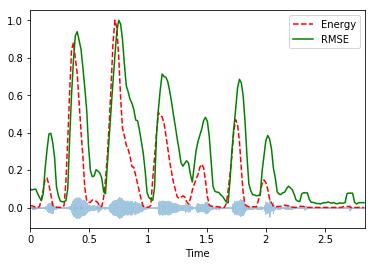

In [12]:
x, sr = librosa.load("/home/muncok/DL/dataset/SV_sets/reddots_r2015q4_v1/wav/f0002/20150211152828571_f0002_275.wav", sr=16000)
striped_x = strip_audio(x, rms_ths=0.2)
ipd.Audio(data=striped_x,rate=sr) 

In [17]:
len(striped_x[0])

30976